In [1]:
import torch
from typing import List, Dict, Tuple
from random import choices

# Support for ARM64 Mac Devices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [2]:
import zipfile as zf
import os

# Extracts Demo Files from ZIP Archives
def extract_demo_files(demo_dir: str = '/Users/mattkingsbury/cs_msc/comp_demos', 
                       expr_dir: str = '/Users/mattkingsbury/cs_msc/decomp_demos') -> None:
    for filename in os.listdir(demo_dir):
        if filename.endswith('.zip'):
            zip_path = os.path.join(demo_dir, filename)
            with zf.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(expr_dir)

extract_demo_files()
demoNames = [fileName for fileName in os.listdir('/Users/mattkingsbury/cs_msc/decomp_demos') if fileName.endswith('dem')]

In [3]:
from awpy import DemoParser
from awpy.analytics.stats import player_stats

# Parses a Demo File into a .json File
def parser(file: str) -> Tuple[str, any]:
    fpath = '/Users/mattkingsbury/cs_msc/decomp_demos/'
    id = ''.join(choices(file, k = 12))
    demo_parser = DemoParser(
        demofile = fpath + file, 
        demo_id = id, 
        parse_rate = 128, 
        trade_time = 5, 
        buy_style = "hltv"
    )

    demo = demo_parser.parse()
    return (id, demo)


In [4]:
from helpers import arr_to_dict, euclidean_distance, add_trajectory

# Retrieves Statistics and Player Trajectories for a Match
def get_team_stats_and_trajectories(demo_and_id: Tuple[str, any]) -> Dict[str, Tuple[List[float], List[float]]]:
    (id, demo) = demo_and_id
    teams: List[str] = [None, None]
    team1_stats: List[float] = [0.] * 14
    team2_stats: List[float] = [0.] * 14
    num_rounds: int = 0

    # Player Stats
    stats_per_player: Dict = player_stats(demo['gameRounds'])
    for stats in stats_per_player.values():
        num_rounds = max(num_rounds, stats['totalRounds'])
        curr_player_team = stats['teamName']
        clutch_successes: List[float] = sum([
            stats['success1v1'], 
            stats['success1v2'], 
            stats['success1v3'], 
            stats['success1v4'], 
            stats['success1v5']])
        clutch_attempts: List[float] = sum([
            stats['attempts1v1'], 
            stats['attempts1v2'], 
            stats['attempts1v3'], 
            stats['attempts1v4'], 
            stats['attempts1v5']])
        curr_player_stats: List[float] = [ 
            stats['kills'], # Kills
            stats['firstKills'], # Entry-Kills
            stats['totalDamageTaken'], # Damage Taken
            stats['hsPercent'], # Player Headshot Percentage
            stats['plants'], # Times Player Planted Bomb
            stats['defuses'], # Times Player Defused Bomb
            stats['flashAssists'], # Count Enemies Flashed + Killed By Team While Blind
            stats['smokesThrown'], # Count Smokes Thrown
            stats['utilityDamage'], # Total Damage Enemies Received From Player Utility (Grenades, Molotovs)
            stats['tradeKills'], # Times Player Killed Enemy Immediately After Enemy Killed Teammate
            clutch_successes / clutch_attempts if clutch_attempts > 0 else None, # Clutch Conversion Probability
            stats['teamKills'] + stats['suicides'] # Sum (Player Killed Teammate, Player Killed Self) 
        ]

        # Separate Stats by Team
        if teams[0] == None or teams[0] == curr_player_team: 
            teams[0] = curr_player_team
            team1_stats = [None if x is None or y is None else x + y for x, y in zip(curr_player_stats, team1_stats)]
        elif teams[1] == None or teams[1] == curr_player_team:
            teams[1] = curr_player_team
            team2_stats = [None if x is None or y is None else x + y for x, y in zip(curr_player_stats, team2_stats)]

    # Sum Team Stats for Bomb and Kill Events
    sum_team1_time_to_plant, team1_num_plants, sum_team1_kills_dist, team1_num_kills = 0, 0, 0, 0
    sum_team2_time_to_plant, team2_num_plants, sum_team2_kills_dist, team2_num_kills = 0, 0, 0, 0
    trajectories:  Dict[str, Dict[int, List[Tuple[float, float]]]] = {}

    # Number of Seconds to Analyse Trajectories
    seconds: int = (lambda x: x if x > 3 else 3)(12)
    for round in demo['gameRounds']:
        for bombEvent in round['bombEvents']:
            if bombEvent['bombAction'] == 'plant':
                if bombEvent['playerTeam'] == teams[0]:
                    sum_team1_time_to_plant += bombEvent['seconds']
                    team1_num_plants += 1
                else:
                    sum_team2_time_to_plant += bombEvent['seconds']
                    team2_num_plants += 1
                break
        for killEvent in round['kills']:
            if killEvent['attackerTeam'] == teams[0]:
                sum_team1_kills_dist += euclidean_distance(
                    (killEvent['attackerX'], killEvent['attackerY'], killEvent['attackerZ']),
                    (killEvent['victimX'], killEvent['victimY'], killEvent['victimZ'])
                )
                team1_num_kills += 1
            else:
                sum_team2_kills_dist += euclidean_distance(
                    (killEvent['attackerX'], killEvent['attackerY'], killEvent['attackerZ']),
                    (killEvent['victimX'], killEvent['victimY'], killEvent['victimZ'])
                )
                team2_num_kills += 1
        for frames in round['frames']:
            if frames['seconds'] >= seconds:
                break
            for team in ['t', 'ct']:
                for player in frames[team]['players']:
                    position: Tuple[float, float] = (player['x'], player['y'])
                    key: str = player['name'] + ':' + str(player['steamID'])
                    add_trajectory(
                        key, 
                        round['roundNum'], 
                        position, 
                        trajectories
                    )

    # Avg Time For Team To Plant Per Round
    avg_team1_plant_time: float = None if team1_num_plants == 0 else sum_team1_time_to_plant / team1_num_plants
    avg_team2_plant_time: float = None if team2_num_plants == 0 else sum_team2_time_to_plant / team2_num_plants

    # Avg Distance Per Kill For Each Team
    avg_team1_kills_dist: float = None if team1_num_kills == 0 else sum_team1_kills_dist / team1_num_kills
    avg_team2_kills_dist: float = None if team2_num_kills == 0 else sum_team2_kills_dist / team2_num_kills

    # Calculate Avg Team Statistics
    team1_stats_pr: List[float] = [
        *(None if stat is None else stat / num_rounds for stat in team1_stats),
        avg_team1_plant_time,
        avg_team1_kills_dist,
    ]

    team2_stats_pr: List[float] = [
        *(None if stat is None else stat / num_rounds for stat in team2_stats),
        avg_team2_plant_time,
        avg_team2_kills_dist
    ]

    round_win_ratio = [0, 0]
    for round in demo['gameRounds']:
        if round['winningTeam'] == teams[0]:
            round_win_ratio[0] += 1
        else:
            round_win_ratio[1] += 1

    # Return Access to Relevant Data
    return {
        "demo": id,
        "stats": (team1_stats_pr, team2_stats_pr),
        "trajectories": trajectories,
        "rounds": num_rounds,
        "round_win_ratio": round_win_ratio
    }

In [5]:
import numpy as np

# Extract Cluster Labels
def cluster(algorithm) -> Tuple[Dict[int, int], np.ndarray]:
    labels = algorithm.labels_
    strategy_map: Dict[int, int] = arr_to_dict(labels) 
    return (strategy_map, labels)

In [6]:
import matplotlib.pyplot as plt

def plot_clusters(trajectories_list: List[np.ndarray], labels: List[str]):
    plt.figure(figsize=(8, 6))

    # Cluster Colours
    unique_labels = sorted(set(labels))
    colors = plt.colormaps.get_cmap('tab20')

    enumerate_labels = list(enumerate(labels))
    for (trajectory, (i, label)) in zip(trajectories_list, enumerate_labels):
        if i % 2 != 0: # Plot every other trajectory
            continue
        if label == -1:
            color = 'k'
            label_text = 'No Group'
        else:
            color = colors(unique_labels.index(label))
            label_text = f'Group {label}'
        plt.plot(trajectory[:, 0], 
                trajectory[:, 1], 
                color = color,
                alpha = 0.5, 
                label = label_text if label_text not in plt.gca().get_legend_handles_labels()[1] else "")

    # Titles and Display Plot
    plt.xlabel('x Coordinate')
    plt.ylabel('y Coordinate')
    plt.show()

In [7]:
from tqdm import trange

# Retrieve Data for All Parsed Demos
all_matches_data = {}
for i in trange(len(demoNames)):
    demo = parser(demoNames[i])
    data = get_team_stats_and_trajectories(demo)
    all_matches_data[data['demo']] = {
        't': data['trajectories'],
        's': data['stats'],
        'n': data['rounds'],
        'r': data['round_win_ratio']
    }

100%|██████████| 120/120 [18:01<00:00,  9.01s/it]


In [8]:
# Collect Data for Clustering
trajectories_list: List[np.ndarray] = []
targets_for_regression = []
round_player_info: Dict[Tuple[int, str], List[Tuple[int, str]]] = {}
for match in all_matches_data:
    num_rounds = all_matches_data[match]['n']
    for player in all_matches_data[match]['t']:
        for round_num, trajectory in all_matches_data[match]['t'][player].items():
            trajectories_list.append(np.array(trajectory))
            key = (num_rounds, match)
            if key not in round_player_info:
                round_player_info[key] = []
            round_player_info[key].append((round_num, player))
    for target_point in all_matches_data[match]['r']:
        targets_for_regression.append(target_point / num_rounds)

In [9]:
from tqdm import trange # Progress Bar
from dtaidistance import dtw # Dynamic Time Warping

# Compute the DTW distance matrix
num_trajectories = len(trajectories_list)
dtw_mtx = np.zeros((num_trajectories, num_trajectories))
for i in trange(num_trajectories):
    for j in range(i + 1, num_trajectories):
        
        # Separate into x and y lists
        ix = np.array([p[0] for p in trajectories_list[i]], dtype = np.double)
        iy = np.array([p[1] for p in trajectories_list[i]], dtype = np.double)
        jx = np.array([p[0] for p in trajectories_list[j]], dtype = np.double)
        jy = np.array([p[1] for p in trajectories_list[j]], dtype = np.double)

        # Calculate distances on x and y time series
        dx = dtw.distance_fast(ix, jx, use_pruning = False)
        dy = dtw.distance_fast(iy, jy, use_pruning = False)
        
        # Recombine results with Euclidean distance
        distance = np.sqrt(dx ** 2 + dy ** 2)

        # Assign result to symmetrical distance matrix
        dtw_mtx[i, j] = distance
        dtw_mtx[j, i] = distance

100%|██████████| 31650/31650 [1:55:36<00:00,  4.56it/s]  


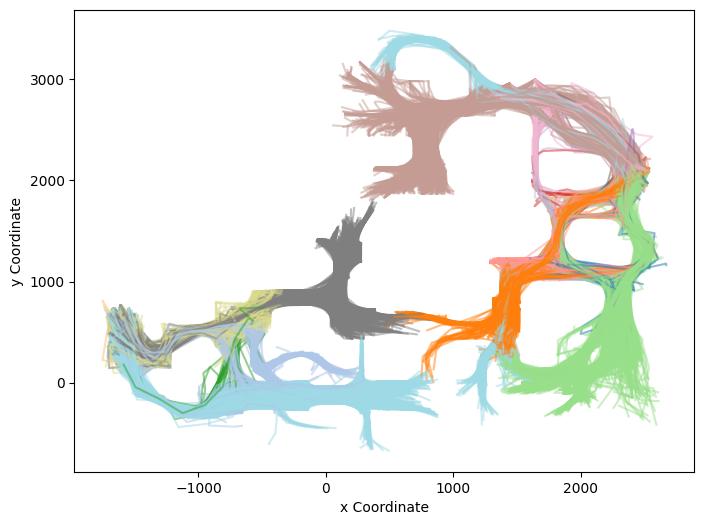

In [10]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering for Individual Trajectories
cluster_agglomerative = AgglomerativeClustering(
    n_clusters = 24,
    linkage = 'average',
    metric = 'precomputed'
).fit(dtw_mtx)

(agg_strategies_map, agg_labels) = cluster(cluster_agglomerative)
plot_clusters(trajectories_list, agg_labels)

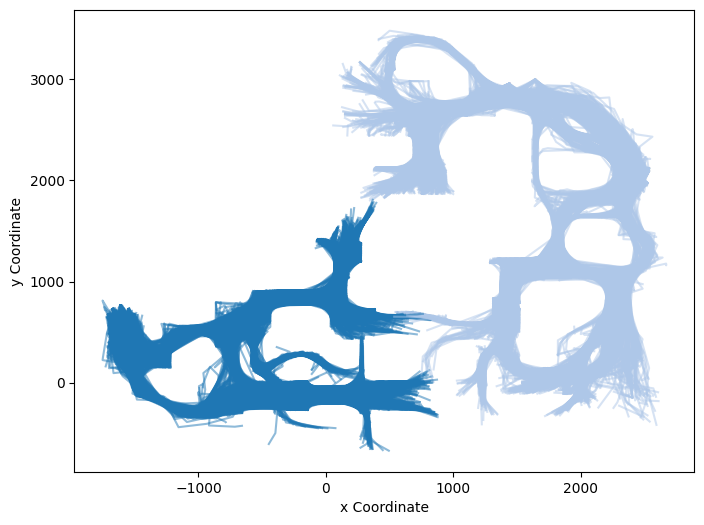

In [11]:
from sklearn.cluster import HDBSCAN

# Perform HDBSCAN clustering
cluster_hdbscan = HDBSCAN(
    min_cluster_size = 5,
    min_samples = 3, 
    n_jobs = 4,
    metric = 'precomputed',
).fit(dtw_mtx)

(hdb_strategies_map, hdb_labels) = cluster(cluster_hdbscan)
plot_clusters(trajectories_list, hdb_labels)

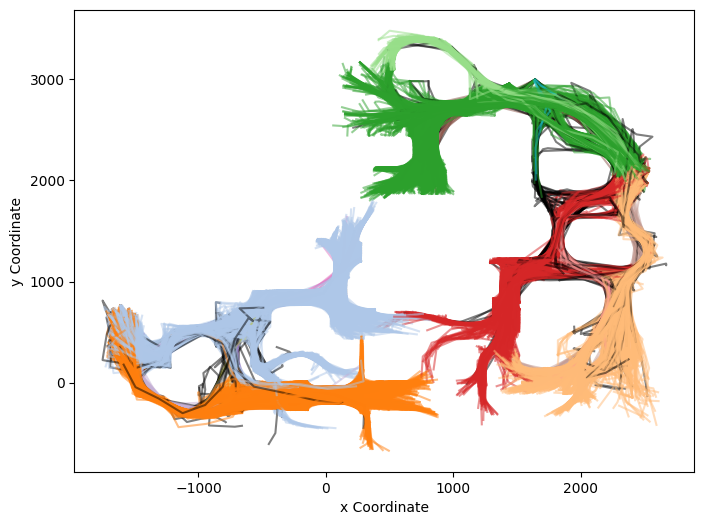

In [12]:
from sklearn.cluster import DBSCAN

# Perform HDBSCAN clustering
cluster_dbscan = DBSCAN(
    eps = 275,
    min_samples = 5,
    metric = 'precomputed',
).fit(dtw_mtx)

(db_strategies_map, db_labels) = cluster(cluster_dbscan)
plot_clusters(trajectories_list, db_labels)

In [13]:
# Map Cluster Labels to Player Trajectories
all_trajectories_per_game_per_team = []
for match_id in round_player_info:
    mid = len(round_player_info[match_id]) // 2
    t1_data = round_player_info[match_id][:mid] # Team 1 Occupies the first half of the data
    t2_data = round_player_info[match_id][mid:] # Team 2 Occupies the second half of the data
    if t1_data[0][0] != 1 or t2_data[0][0] != 1:
        raise Exception("Data has not split correctly.")
    t1_round_trajectories = {}
    t2_round_trajectories = {}
    label_list = agg_labels.tolist()
    for (round_number, _) in t1_data:
        if round_number not in t1_round_trajectories:
            t1_round_trajectories[round_number] = []
        t1_round_trajectories[round_number].append(label_list.pop(0))
    for (round_number, _) in t2_data:
        if round_number not in t2_round_trajectories:
            t2_round_trajectories[round_number] = []
        t2_round_trajectories[round_number].append(label_list.pop(0))
    all_trajectories_per_game_per_team.append(list(t1_round_trajectories.values()))
    all_trajectories_per_game_per_team.append(list(t2_round_trajectories.values()))
print("- - -Example Trajectories for a Team on a Singular Map- - -")
print("Array: [A, B, C, D, E] Represents Initial Trajectories of a Team in a Given Round")
print("Values: The Cluster Label for the input Trajectory (the Grouping)")
all_trajectories_per_game_per_team[0]

- - -Example Trajectories for a Team on a Singular Map- - -
Array: [A, B, C, D, E] Represents Initial Trajectories of a Team in a Given Round
Values: The Cluster Label for the input Trajectory (the Grouping)


[[14, 20, 17, 1, 1],
 [20, 20, 14, 14, 14],
 [1, 20, 14, 17, 14],
 [20, 20, 14, 14, 17],
 [1, 20, 14, 14, 17],
 [20, 20, 17, 14, 14],
 [20, 20, 14, 14, 14],
 [20, 20, 1, 1, 20],
 [20, 17, 14, 14, 14],
 [20, 20, 14, 20, 14],
 [20, 20, 14, 14, 17],
 [20, 20, 14, 17, 14],
 [20, 20, 14, 20, 14],
 [20, 17, 14, 17, 17],
 [20, 20, 14, 17, 17],
 [5, 11, 11, 21, 5],
 [5, 11, 11, 5, 5],
 [5, 11, 11, 5, 7],
 [5, 11, 11, 2, 2],
 [5, 11, 11, 11, 2],
 [11, 11, 11, 11, 11],
 [5, 11, 11, 5, 5],
 [5, 11, 11, 11, 5],
 [5, 11, 11, 11, 5],
 [5, 11, 11, 2, 7],
 [5, 13, 11, 5, 0],
 [5, 21, 11, 5, 5]]

In [14]:
from sklearn.metrics import pairwise_distances
from helpers import jaccard_distance

flat_trajectories_sets: List[set] = []
for arr in all_trajectories_per_game_per_team:
    flat_trajectories_sets += map(set, arr)

jaccards = pairwise_distances(
    flat_trajectories_sets, 
    metric = jaccard_distance
)

clustering = AgglomerativeClustering(
    n_clusters = 8,
    metric = 'precomputed', 
    linkage = 'complete'
)

labels = clustering.fit_predict(jaccards)
print("Team Strategy Labels per Round")
print(labels)

Team Strategy Labels per Round
[5 7 5 ... 7 7 7]


In [15]:
i = 0
map_vals: Dict[int, List] = {}
for team_openings in all_trajectories_per_game_per_team:
    for opening_strat in team_openings:
        label = labels[i].astype(int)
        if label not in map_vals:
            map_vals[label] = []
        map_vals[label].append(sorted(opening_strat, reverse = True))
        i += 1

for k, v in map_vals.items():
    print("Cluster", str(k) + ": ", str(len(v)))

Cluster 5:  203
Cluster 7:  889
Cluster 2:  1293
Cluster 6:  689
Cluster 0:  1251
Cluster 4:  770
Cluster 3:  387
Cluster 1:  848


In [16]:
from itertools import combinations
from helpers import jaccard_distance

# Calculates Avg. Similarity across All Clusters
def calculate_average_similarity(clusters: Dict[int, List]) -> Tuple[Dict, float]:
    cluster_similarities = {}
    all_similarities = []
    for cluster_id, elements in clusters.items():
        if len(elements) < 2:
            cluster_similarities[cluster_id] = None
            continue

        pairwise_similarities = [
            (1 - jaccard_distance(set(el1), set(el2))) for el1, el2 in combinations(elements, 2)
        ]
        cluster_avg_similarity = np.mean(pairwise_similarities)
        cluster_similarities[cluster_id] = cluster_avg_similarity
        all_similarities.extend(pairwise_similarities)
    
    overall_average_similarity = np.mean(all_similarities) if all_similarities else None
    return (cluster_similarities, overall_average_similarity)

# Calculate and print the similarities
cluster_similarities_j, overall_average_similarity_j = calculate_average_similarity(map_vals)
print("Jaccard Similarities:")
for cluster_id, similarity in cluster_similarities_j.items():
    print(f"Cluster {cluster_id}: {similarity:.2f}" if similarity is not None else f"Cluster {cluster_id}: Not enough elements")

Jaccard Similarities:
Cluster 5: 0.80
Cluster 7: 0.77
Cluster 2: 0.54
Cluster 6: 0.64
Cluster 0: 0.55
Cluster 4: 0.76
Cluster 3: 0.57
Cluster 1: 0.56


In [17]:
from helpers import hamming_distance

# Calculates Avg. Similarity across All Clusters
def calculate_hamming_similarity(clusters: Dict[int, List]) -> Tuple[Dict, float]:
    cluster_similarities = {}
    all_similarities = []
    for cluster_id, elements in clusters.items():
        if len(elements) < 2:
            cluster_similarities[cluster_id] = None
            continue

        pairwise_similarities = [
            hamming_distance(sorted(el1), sorted(el2)) for el1, el2 in combinations(elements, 2)
        ]
        cluster_avg_similarity = np.mean(pairwise_similarities)
        cluster_similarities[cluster_id] = cluster_avg_similarity
        all_similarities.extend(pairwise_similarities)
    
    overall_average_similarity = np.mean(all_similarities) if all_similarities else None
    return (cluster_similarities, overall_average_similarity)

# Calculate and print the similarities
cluster_similarities_h, overall_average_similarity_h = calculate_hamming_similarity(map_vals)
print("Hamming Distances:")
for cluster_id, similarity in cluster_similarities_h.items():
    print(f"Cluster {cluster_id}: {similarity:.2f}" if similarity is not None else f"Cluster {cluster_id}: Not enough elements")

Hamming Distances:
Cluster 5: 1.86
Cluster 7: 1.82
Cluster 2: 3.33
Cluster 6: 2.43
Cluster 0: 2.96
Cluster 4: 1.97
Cluster 3: 2.58
Cluster 1: 2.79


In [18]:
strategies_for_regression = []
li_labels = list(labels)
for arr in all_trajectories_per_game_per_team:
    strategies_employed = [0] * len(map_vals.keys())
    for i in range(len(arr)):
        strategies_employed[li_labels.pop(0)] += 1
    strategies_for_regression.append([x / len(arr) for x in strategies_employed])

In [19]:
data_for_regression = []
for k, v in all_matches_data.items():
    data_for_regression.append(v['s'][0])
    data_for_regression.append(v['s'][1])

for row in data_for_regression:
    row += strategies_for_regression.pop(0)

In [164]:
import pandas as pd

df = pd.DataFrame(data_for_regression)
df = df.loc[:, (df != 0).any(axis=0)]
df = df.fillna(df.mean())
print("Rows:", str(df.shape[0]))
print("Cols:", str(df.shape[1]))
df.head()

Rows: 240
Cols: 21


,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,3.185185,0.592593,343.074074,0.072593,0.259259,0.037037,3.000000,39.518519,0.518519,0.024191,...,71.101562,632.737941,0.111111,0.000000,0.259259,0.000000,0.074074,0.148148,0.259259,0.148148
1,2.703704,0.407407,367.888889,0.090741,0.222222,0.000000,3.037037,20.740741,0.370370,0.000000,...,78.446615,643.672582,0.148148,0.000000,0.148148,0.037037,0.333333,0.000000,0.074074,0.259259
2,2.227273,0.454545,390.409091,0.085000,0.136364,0.000000,2.772727,33.681818,0.409091,0.000000,...,68.622396,695.119510,0.409091,0.090909,0.181818,0.136364,0.000000,0.000000,0.136364,0.045455
3,3.500000,0.545455,324.681818,0.143182,0.500000,0.000000,3.000000,41.409091,0.636364,0.024191,...,71.729403,564.464495,0.318182,0.318182,0.227273,0.045455,0.000000,0.000000,0.000000,0.090909
4,3.727273,0.590909,321.227273,0.066818,0.318182,0.045455,2.954545,35.590909,0.545455,0.024191,...,64.793527,584.447526,0.409091,0.090909,0.181818,0.136364,0.000000,0.000000,0.136364,0.045455


<Axes: >

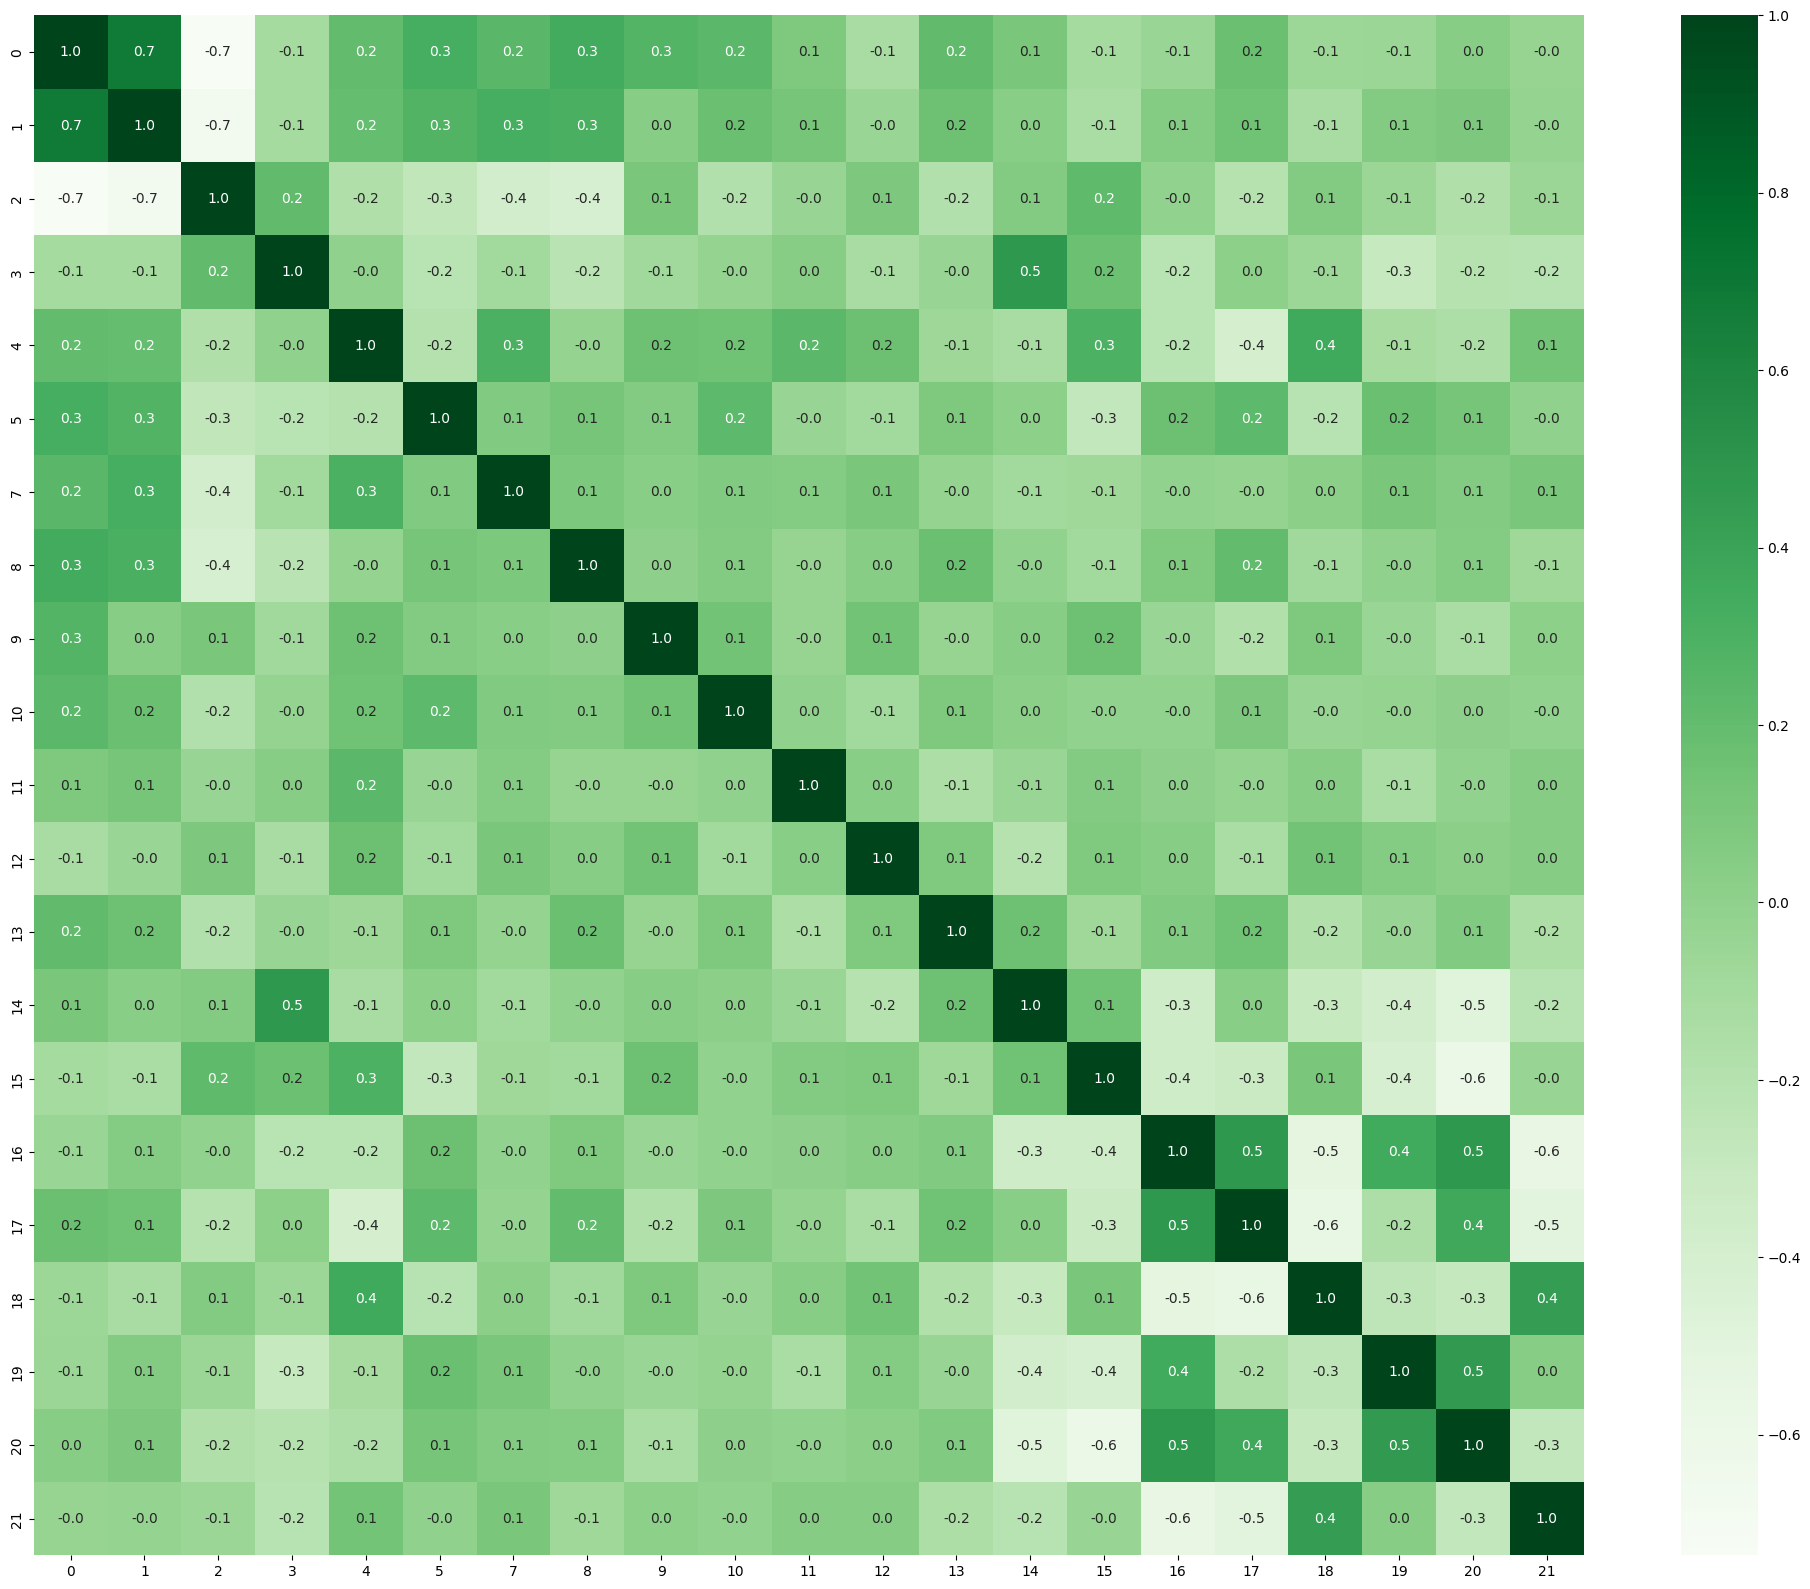

In [165]:
import seaborn

corr = df.corr()
plt.figure(figsize=(25,20))
seaborn.heatmap(corr, cmap="Greens", annot=True, fmt=".1f")

In [166]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
print("Rows:", str(df.shape[0]))
print("Cols:", str(df.shape[1]))
df.head()

Rows: 240
Cols: 21


,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0.457239,0.658730,0.403528,0.219927,0.341880,0.111111,0.541524,0.501650,0.323516,0.203207,...,0.531087,0.452698,0.147977,0.000000,0.648148,0.000000,0.222222,1.0,0.962963,0.460905
1,0.308418,0.341270,0.499797,0.334753,0.282051,0.000000,0.556862,0.149383,0.145025,0.000000,...,0.623723,0.493186,0.223417,0.000000,0.370370,0.207407,1.000000,0.0,0.275132,0.806584
2,0.161157,0.422078,0.587164,0.298431,0.143357,0.000000,0.447409,0.392155,0.191676,0.000000,...,0.499819,0.683682,0.754922,0.285714,0.454545,0.763636,0.000000,0.0,0.506494,0.141414
3,0.554545,0.577922,0.332175,0.666556,0.730769,0.000000,0.541524,0.537117,0.465498,0.203207,...,0.539005,0.199898,0.569753,1.000000,0.568182,0.254545,0.000000,0.0,0.000000,0.282828
4,0.624793,0.655844,0.318773,0.183392,0.437063,0.136364,0.522701,0.427969,0.355969,0.203207,...,0.451529,0.273890,0.754922,0.285714,0.454545,0.763636,0.000000,0.0,0.506494,0.141414


Number of resulting features: 19


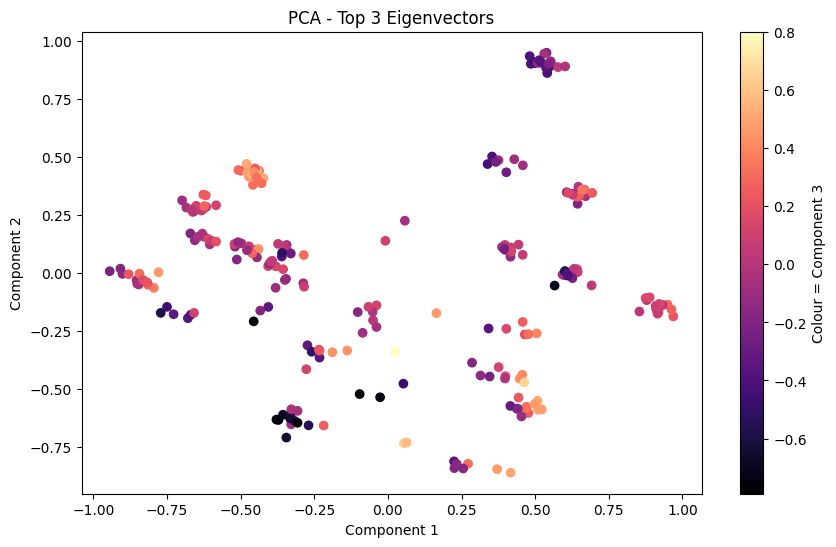

In [167]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
pca_data = pca.fit_transform(df)

features = pca_data.shape[1]
print("Number of resulting features:", str(features))

df_pca = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['PC3'], cmap='magma')
plt.colorbar(scatter, label='Colour = Component 3')
plt.title('PCA - Top 3 Eigenvectors')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df, 
    pd.DataFrame(targets_for_regression), 
    test_size = 0.25, 
    random_state = 141
)

# Oversample X_train: extend with noisy duplication of original data
n = np.random.normal(0, 0.05, X_train.shape)
X_train_n = X_train + n

# X_train and y_train must have same shape
X_train = pd.concat([X_train, X_train_n], axis=0)
y_train = pd.concat([y_train, y_train], axis=0)

# Fit a Decision Tree Regression Model
decision_tree_model = DecisionTreeRegressor(random_state = 141)
decision_tree_model.fit(X_train, y_train)

print("Rows:", str(X_train.shape[0]))
print("Cols:", str(X_train.shape[1]))
X_train.head()

Rows: 360
Cols: 21


,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
150,0.455195,0.500000,0.424162,0.147031,0.153846,0.107143,0.585893,0.359264,0.387263,0.000000,...,0.594295,0.501858,0.067149,0.224490,0.892857,1.000000,0.107143,0.00,0.928571,0.111111
235,0.571717,0.531746,0.388010,0.224614,0.641026,0.222222,0.771584,0.227896,0.412762,0.203207,...,0.645893,0.288691,0.223417,0.000000,0.370370,0.207407,1.000000,0.00,0.275132,0.806584
62,0.437091,0.191429,0.609010,0.274387,0.052308,0.360000,0.640910,0.666764,0.373494,0.000000,...,0.714602,0.213603,0.166083,0.377143,0.900000,0.672000,0.120000,0.54,0.445714,0.124444
56,0.343802,0.032468,0.613439,0.269671,0.069930,0.272727,0.372117,0.404946,0.520263,0.190909,...,0.549020,0.369147,0.754922,0.285714,0.454545,0.763636,0.000000,0.00,0.506494,0.141414
189,0.541667,0.571429,0.416980,0.419701,0.663462,0.000000,0.593288,0.372329,0.351406,0.116667,...,0.733641,0.523626,0.176267,0.785714,0.416667,0.000000,0.500000,0.00,0.619048,0.388889


In [173]:
feature_importances = decision_tree_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(
    by = 'Importance', 
    ascending = False).reset_index(drop = True)

results = {}
importance_df

,Feature,Importance
0,0,0.546542
1,2,0.155670
2,14,0.140310
3,21,0.027285
4,1,0.020543
5,16,0.015647
6,18,0.015402
7,3,0.011987
8,9,0.011007
9,10,0.009978


In [174]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_dt = decision_tree_model.predict(X_test)

results['DT'] = {
    'MSE': mean_squared_error(y_test, y_pred_dt),
    'MAE': mean_absolute_error(y_test, y_pred_dt),
    'R^2': r2_score(y_test, y_pred_dt)
}

In [175]:
from sklearn.svm import SVR

svl_model = SVR(kernel = 'linear')
svl_model.fit(X_train, y_train.values.ravel())

y_pred_svl = svl_model.predict(X_test)

results['SVL'] = {
    'MSE': mean_squared_error(y_test, y_pred_svl),
    'MAE': mean_absolute_error(y_test, y_pred_svl),
    'R^2': r2_score(y_test, y_pred_svl)
}

In [176]:
svp_model = SVR(
    kernel = 'poly', 
    degree = 2
)
svp_model.fit(X_train, y_train.values.ravel())

y_pred_svm_poly = svp_model.predict(X_test)

results['SVP2'] = {
    'MSE': mean_squared_error(y_test, y_pred_svm_poly),
    'MAE': mean_absolute_error(y_test, y_pred_svm_poly),
    'R^2': r2_score(y_test, y_pred_svm_poly)
}

In [177]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    random_state = 64, 
    n_estimators = 10,
    max_features = 'sqrt'
)
rf_model.fit(X_train, y_train.values.ravel())

y_pred_rf = rf_model.predict(X_test)

results['RF'] = {
    'MSE': mean_squared_error(y_test, y_pred_svm_poly),
    'MAE': mean_absolute_error(y_test, y_pred_svm_poly),
    'R^2': r2_score(y_test, y_pred_svm_poly)
}

In [178]:
results

{'DT': {'MSE': 0.005463910843739397,
  'MAE': 0.041228121786678444,
  'R^2': 0.8002486134545657},
 'SVL': {'MSE': 0.004839048609351864,
  'MAE': 0.056359732688087,
  'R^2': 0.8230925253133773},
 'SVP2': {'MSE': 0.004709471944678708,
  'MAE': 0.05628977894343576,
  'R^2': 0.8278296301404175},
 'RF': {'MSE': 0.004709471944678708,
  'MAE': 0.05628977894343576,
  'R^2': 0.8278296301404175}}